In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from kmodes.kprototypes import KPrototypes
from plotnine import *
import plotnine

In [37]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import operator
import string
import itertools
import operator
import re
%matplotlib inline

from sklearn import preprocessing

In [2]:
vgsales = pd.read_csv('vgsales.csv')
video_game_sales = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
game_reviews = pd.read_csv('metacritic_critic_reviews.csv')

In [3]:
#Get the unique game names from vgsales
vgsales['Name'] = vgsales['Name'].str.lower()
unique_vgsales = vgsales.groupby(['Name','Platform']).count()
unique_vgsales.reset_index(drop = False, inplace = True)
unique_vgsales = unique_vgsales.iloc[:,0:2]
print(unique_vgsales.shape)
unique_vgsales.head()

(16593, 2)


,Name,Platform
0,'98 koshien,PS
1,.hack//g.u. vol.1//rebirth,PS2
2,.hack//g.u. vol.2//reminisce,PS2
3,.hack//g.u. vol.2//reminisce (jp sales),PS2
4,.hack//g.u. vol.3//redemption,PS2


In [4]:
#Get the unique game names from video_game_sales
video_game_sales['Name'] = video_game_sales['Name'].str.lower()
unique_video_game_sales = video_game_sales.groupby(['Name','Platform']).count()
unique_video_game_sales.reset_index(drop = False, inplace = True)
unique_video_game_sales = unique_video_game_sales.iloc[:,0:2]
print(unique_video_game_sales.shape)
unique_video_game_sales.head()

(16713, 2)


,Name,Platform
0,beyblade burst,3DS
1,fire emblem fates,3DS
2,frozen: olaf's quest,3DS
3,frozen: olaf's quest,DS
4,haikyu!! cross team match!,3DS


In [5]:
#Change the platform format in game_reviews to make them aligned with the other two tables
game_reviews.replace("PlayStation 4", "PS4", inplace=True)
game_reviews.replace("PlayStation Vita", "PSV", inplace=True)
game_reviews.replace("Wii U", "WiiU", inplace=True)
game_reviews.replace("Xbox One", "XOne", inplace=True)

In [6]:
#Get the unique game names from game_reviews
game_reviews['game'] = game_reviews['game'].str.lower()
unique_game_reviews = game_reviews.groupby(['game','platform']).count()
unique_game_reviews.reset_index(drop = False, inplace = True)
unique_game_reviews = unique_game_reviews.iloc[:,0:2]
print(unique_game_reviews.shape)
unique_game_reviews.head()

(5516, 2)


,game,platform
0,#idarb,XOne
1,.hack//g.u. last recode,PC
2,.hack//g.u. last recode,PS4
3,0rbitalis,PC
4,1-2-switch,Switch


## Games Clustering

In [7]:
#inspect the data
video_game_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [11]:
#inspect the object categorical variables
video_game_sales.select_dtypes('object').nunique()

Name          11562
Platform         31
Genre            12
Publisher       581
User_Score       96
Developer      1696
Rating            8
dtype: int64

In [13]:
#check the missing value
video_game_sales.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [15]:
#impute missing value
video_game_sales_imp=pd.concat([video_game_sales.select_dtypes(include=np.number).fillna(-0.1),
                              video_game_sales.select_dtypes(exclude=np.number).fillna('None')],
                              axis=1)
video_game_sales_imp.loc[video_game_sales_imp['User_Score'].str.isnumeric()!=True, 'User_Score']=-0.1
video_game_sales_imp['User_Score']=video_game_sales_imp['User_Score'].astype('float')
video_game_sales_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year_of_Release  16719 non-null  float64
 1   NA_Sales         16719 non-null  float64
 2   EU_Sales         16719 non-null  float64
 3   JP_Sales         16719 non-null  float64
 4   Other_Sales      16719 non-null  float64
 5   Global_Sales     16719 non-null  float64
 6   Critic_Score     16719 non-null  float64
 7   Critic_Count     16719 non-null  float64
 8   User_Count       16719 non-null  float64
 9   Name             16719 non-null  object 
 10  Platform         16719 non-null  object 
 11  Genre            16719 non-null  object 
 12  Publisher        16719 non-null  object 
 13  User_Score       16719 non-null  float64
 14  Developer        16719 non-null  object 
 15  Rating           16719 non-null  object 
dtypes: float64(10), object(6)
memory usage: 2.0+ MB


### Numerical Analysis

In [80]:
#inspect numerical variables
video_game_sales.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000


In [17]:
## Dealing wiht Sales information
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import silhouette_score

video_game_sales_label=video_game_sales_imp.filter(regex='Sales$', axis=1)
video_game_sales_percent=video_game_sales_label.copy()
video_game_sales_percent['NA_Sales']=video_game_sales_percent['NA_Sales']/video_game_sales_percent['Global_Sales']
video_game_sales_percent['EU_Sales']=video_game_sales_percent['EU_Sales']/video_game_sales_percent['Global_Sales']
video_game_sales_percent['JP_Sales']=video_game_sales_percent['JP_Sales']/video_game_sales_percent['Global_Sales']
video_game_sales_percent['Other_Sales']=video_game_sales_percent['Other_Sales']/video_game_sales_percent['Global_Sales']

video_game_sales_percent.drop(['Global_Sales'], axis=1, inplace=True)

In [19]:
kmeans_kwargs={
    'init':'random',
    'n_init':10,
    'max_iter': 300,
    'random_state':42
}

silhouette_coefficients=[]
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(video_game_sales_percent)
    score = silhouette_score(video_game_sales_percent, kmeans.labels_)
    silhouette_coefficients.append(score)

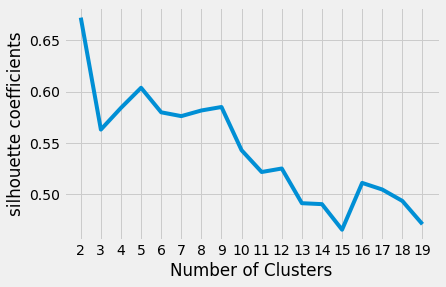

In [20]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("silhouette coefficients")
plt.show()

In [21]:
kmeans_kwargs={
    'init':'random',
    'n_init':10,
    'max_iter': 300,
    'random_state':42
}

sse=[]
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(video_game_sales_percent)
    #score = silhouette_score(video_game_sales_label, kmeans.labels_)
    sse.append(kmeans.inertia_)

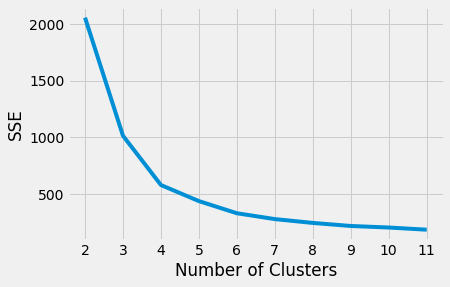

In [22]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 12), sse)
plt.xticks(range(2, 12))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [33]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(video_game_sales_percent)
sales_label = kmeans.labels_

video_game_sales_percent['sales_label']=pd.Series(sales_label).replace(
    {0:'JP&NA', 1:'NA', 2:'JP', 3:'NA&EU',4:'EU'})
video_game_sales_percent.groupby('sales_label').mean()

ValueError: could not convert string to float: 'NA&EU'

In [34]:
video_game_sales_percent['sales_label'].value_counts()

NA       5705
NA&EU    4953
JP       3574
EU       1490
JP&NA     997
Name: sales_label, dtype: int64

### Numerical Analysis

<AxesSubplot:>

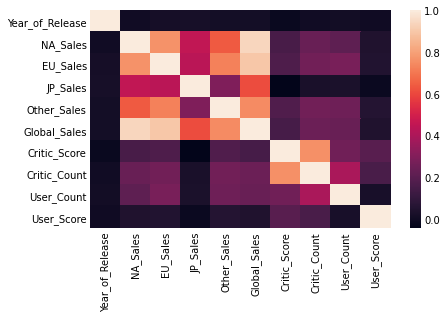

In [43]:
#inspect the numerical variables corr
video_game_sales_num = video_game_sales_imp[video_game_sales_imp.select_dtypes(include=np.number).columns.tolist()]
min_max_scaler=preprocessing.MinMaxScaler()
video_game_sales_scaled=pd.DataFrame(min_max_scaler.fit_transform(video_game_sales_num))
video_game_sales_scaled.columns=video_game_sales_num.columns
sns.heatmap(video_game_sales_scaled.corr())

<AxesSubplot:title={'center':'Global_Sales'}, xlabel='[interval_2020]'>

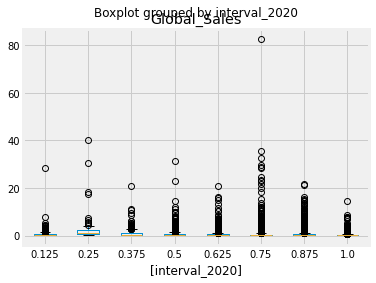

In [45]:
#Deal wiht the year information and add year label for every 5 years interval between 1980 and 2020
def year_label(x):
    x_label=0.125
    if x>=1985 and x<1990:
        x_label=0.25
    elif x>=1990 and x<1995:
        x_label=0.375
    elif x>=1995 and x<2000:
        x_label=0.5
    elif x>=2000 and x<2005:
        x_label=0.625
    elif x>=2005 and x<2010:
        x_label=0.75
    elif x>=2010 and x<2015:
        x_label=0.875
    elif x>=2015:
        x_label=1
    return x_label

#video_game_sales_imp['interval_2020']=video_game_sales['Year_of_Release'].apply(year_label)
video_game_sales_imp.boxplot(column=['Global_Sales'], by=['interval_2020'])

-4.605170185988091

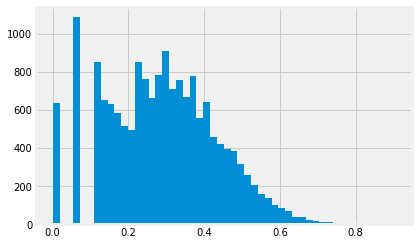

In [75]:
#np.log(video_game_sales[(video_game_sales['Global_Sales']>0) & (video_game_sales['Global_Sales']<0.3)]['Global_Sales']).hist(bins=50)#.plot.hist(bins=10)
((np.log(video_game_sales['Global_Sales'])-np.log(video_game_sales['Global_Sales']).min()+0.01)/10).hist(bins=50)
np.log(video_game_sales['Global_Sales']).min()
#np.log(video_game_sales['Global_Sales']).hist(bins=500)

In [60]:
games_train_num=video_game_sales_scaled[['Critic_Score','User_Count', 'User_Score']]
games_train_num['interval_years_2020']=video_game_sales['Year_of_Release'].apply(year_label)
games_train_num['gloabl_sales_log']=(np.log(video_game_sales['Global_Sales'])-np.log(video_game_sales['Global_Sales']).min()+0.01)/10
games_train_num.head()

/Users/cy/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/cy/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Critic_Score,User_Count,User_Score,interval_years_2020,gloabl_sales_log
0,0.775739,0.030201,0.89011,0.75,0.902833
1,0.000000,0.000000,0.00000,0.25,0.831003
2,0.836901,0.066488,0.00000,0.75,0.818527
3,0.816514,0.018012,0.89011,0.75,0.810468
4,0.000000,0.000000,0.00000,0.50,0.806102


### Categorical Analysis

In [58]:
## get the correlation between categorical variables
from scipy.stats import chisquare
df_games_cat=video_game_sales_imp.drop(columns=['Name', 'Publisher']).select_dtypes(exclude=np.number).apply(lambda x: pd.factorize(x)[0])+1
pd.DataFrame([chisquare(df_games_cat[x].values, f_exp=df_games_cat.values.T, axis=1)[1] for x in df_games_cat])

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0


In [62]:
games_train_cat=video_game_sales_imp.drop(columns=['Name', 'Publisher', 'Developer']).select_dtypes(exclude=np.number)
games_train_cat['regional_sales_label']=pd.Series(sales_label).replace(
    {0:'JP&NA', 1:'NA', 2:'JP', 3:'NA&EU',4:'EU'})
games_train_cat

,Platform,Genre,Rating,regional_sales_label
0,Wii,Sports,E,NA&EU
1,NES,Platform,None,NA
2,Wii,Racing,E,NA&EU
3,Wii,Sports,E,NA&EU
4,GB,Role-Playing,None,JP&NA
...,...,...,...,...
16714,PS3,Action,None,JP
16715,X360,Sports,None,EU
16716,PSV,Adventure,None,JP
16717,GBA,Platform,None,NA


### Modeling Process

In [63]:
# Convert dataframe to matrix
games_train = pd.concat([games_train_cat, games_train_num], axis=1)
games_matrix=games_train.to_numpy()
games_matrix

array([['Wii', 'Sports', 'E', ..., 0.8901098901098901, 0.75,
        0.9028332049592682],
       ['NES', 'Platform', 'None', ..., 0.0, 0.25, 0.8310031711779574],
       ['Wii', 'Racing', 'E', ..., 0.0, 0.75, 0.818526610411206],
       ...,
       ['PSV', 'Adventure', 'None', ..., 0.0, 1.0, 0.001],
       ['GBA', 'Platform', 'None', ..., 0.0, 0.625, 0.001],
       ['PSV', 'Simulation', 'None', ..., 0.0, 1.0, 0.001]], dtype=object)

In [77]:
games_train.head()

,Platform,Genre,Rating,regional_sales_label,Critic_Score,User_Count,User_Score,interval_years_2020,gloabl_sales_log
0,Wii,Sports,E,NA&EU,0.775739,0.030201,0.89011,0.75,0.902833
1,NES,Platform,None,NA,0.000000,0.000000,0.00000,0.25,0.831003
2,Wii,Racing,E,NA&EU,0.836901,0.066488,0.00000,0.75,0.818527
3,Wii,Sports,E,NA&EU,0.816514,0.018012,0.89011,0.75,0.810468
4,GB,Role-Playing,None,JP&NA,0.000000,0.000000,0.00000,0.50,0.806102


In [79]:
# Choose optimal K using Elbow method
cost = []
catColumnsPos=[games_train.columns.get_loc(col) for col in games_train_cat.columns.to_list()]
for cluster in range(1, 40):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(games_matrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 40), 'Cost':cost})


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10
Cluster initiation: 11
Cluster initiation: 12
Cluster initiation: 13
Cluster initiation: 14
Cluster initiation: 15
Cluster initiation: 16
Cluster initiation: 17
Cluster initiation: 18
Cluster initiation: 19
Cluster initiation: 20
Cluster initiation: 21
Cluster initiation: 22
Cluster initiation: 23
Cluster initiation: 24
Cluster initiation: 25
Cluster initiation: 26
Cluster initiation: 27
Cluster initiation: 28
Cluster initiation: 29
Cluster initiation: 30
Cluster initiation: 31
Cluster initiation: 32
Cluster initiation: 33
Cluster initiation: 34
Cluster initiation: 35
Cluster initiation: 36
Cluster initiation: 37
Cluster initiation: 38
Cluster initiation: 39


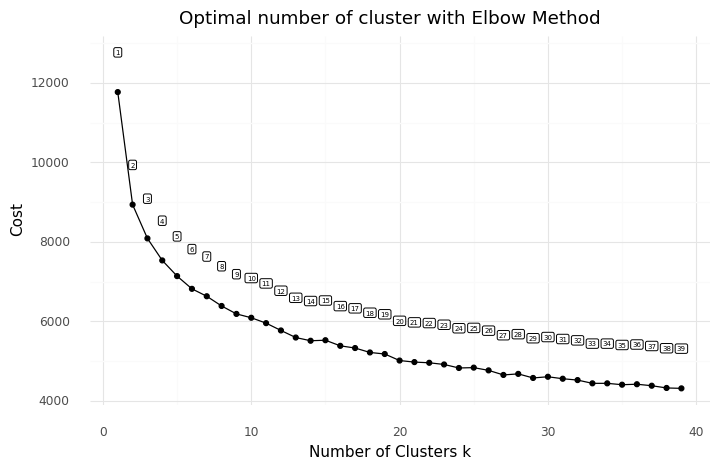

<ggplot: (329598837)>

In [85]:
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 5,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [82]:
cost

[11772.218785158182,
 8938.64684644775,
 8088.553020256321,
 7534.275862017672,
 7139.462634162154,
 6819.156268858462,
 6632.223566354472,
 6387.722336844504,
 6187.838445039609,
 6090.946259673881,
 5955.260838598308,
 5771.3772439163895,
 5593.308643235284,
 5512.20101246978,
 5525.303350681044,
 5384.394147841987,
 5328.660567635463,
 5217.534133607779,
 5178.241811113827,
 5013.762647047159,
 4974.830416773003,
 4957.440297681032,
 4915.039425293238,
 4826.546640722536,
 4835.363876283631,
 4766.184862085449,
 4651.577963652415,
 4678.097057514719,
 4575.5961041217715,
 4605.584873735361,
 4555.992274788895,
 4521.798607149712,
 4440.000804555151,
 4439.864682241456,
 4405.626150954852,
 4417.465836878993,
 4380.011235036608,
 4323.676311552119,
 4313.332716631163]